# About
An implementation of a Conditional GAN on the anime scratch colorization dataset.  
Useful refs:  
1) https://arxiv.org/abs/1611.07004 - Image-to-Image Translation with Conditional Adversarial Networks.  
2) https://www.youtube.com/watch?v=SuddDSqGRzg&ab_channel=AladdinPersson - tutorial of the implementation.

My goal in this work is to gain an understanding of the PatchGAN discriminator implementation and implement Conditional GAN.

In [2]:
try:
    import lightning
except ImportError:
    !pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 51.7 MB/s eta 0:00:00


In [3]:
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

 Dataset: https://www.kaggle.com/datasets/ktaebum/anime-sketch-colorization-pair

You have to load a .env with parameters below:

In [4]:
from dotenv import load_dotenv
import os

load_dotenv('.env')

NGROC_TOKEN = os.getenv("NGROC_TOKEN")
PATH_TO_DATA_ROOT = os.getenv("PATH_TO_DATA_ROOT")
PATH_TO_CHECKPOINT = os.getenv("PATH_TO_CHECKPOINT") # after train you will have checkpoints
WORKING_IMAGE_SIZE = int(os.getenv("WORKING_IMAGE_SIZE", 256))
BATCH_SIZE = int(os.getenv("BATCH_SIZE", 4))
BETAS1 = float(os.getenv("BETAS1", 0.5))
BETAS2 = float(os.getenv("BETAS2", 0.999))
LEARNING_RATE = float(os.getenv("LEARNING_RATE", 2e-4))
BETAS = (BETAS1, BETAS2)
L1_LAMBDA = int(os.getenv("L1_LAMBDA", 100))

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from lightning.pytorch import loggers as pl_loggers
from torchvision.utils import make_grid

In [7]:
!rm -r /content/pytorch-anime-style-transfer
!git clone https://github.com/ThViviani/pytorch-anime-style-transfer.git

import sys
sys.path.append('./pytorch-anime-style-transfer')

rm: cannot remove '/content/pytorch-anime-style-transfer': No such file or directory
Cloning into 'pytorch-anime-style-transfer'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 190 (delta 121), reused 121 (delta 57), pack-reused 0 (from 0)
Receiving objects: 100% (190/190), 1.57 MiB | 27.28 MiB/s, done.
Resolving deltas: 100% (121/121), done.


# Data loading

(512, 1024, 3)


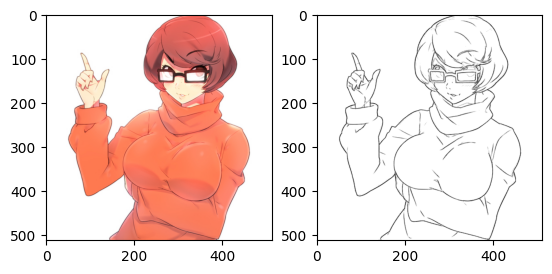

In [8]:
train_files = os.listdir(PATH_TO_DATA_ROOT + "train")
img_file = train_files[0]
img_path = os.path.join(PATH_TO_DATA_ROOT + "train", img_file)
img = np.array(Image.open(img_path))
print(img.shape)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[:, :512, :])
ax[1].imshow(img[:, 512:, :])

In [9]:
class AnimeSketchDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        target_image = image[:, :512, :]
        input_image = image[:, 512:, :]

        input_image = Image.fromarray(input_image)
        target_image = Image.fromarray(target_image)

        transform = transforms.Compose([
            transforms.Resize((WORKING_IMAGE_SIZE, WORKING_IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        input_image = transform(input_image)
        target_image = transform(target_image)

        return input_image, target_image

In [10]:
train_dataset = AnimeSketchDataset(PATH_TO_DATA_ROOT + "train")
# val_dataset = AnimeSketchDataset(PATH_TO_DATA_ROOT + "val")

In [11]:
len(train_dataset)

147

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


# Model fitting

The conditional GANs learn a mapping from observed image $x$ and random noise vector $z$, to $y$, $G : {x,z} → y$. The generator $G$ is trained to produce outputs that cannot be distinguished from “real” images by an adversarially trained discriminator, $D$, which is trained to do as well as possible at detecting the generator’s “fakes”.

The objective of a conditional GAN can be expressed as  
$\mathcal{L}_{cGAN}(G, D) = \mathbb{E}_{x,y} [\log D(x, y)] + \mathbb{E}_{x, z} [\log(1 - D(x, G(x, z)))]
$.

Previous approaches have found it beneficial to mix the GAN objective with a more traditional loss, such as L2 distance or L1  
$\mathcal{L}_{L1}(G) = \mathbb{E}_{x,y,z} [||y - G(x, z)||_1]
$.

Final optimization task:  
$G^* = arg min_{G} max_{D} \mathcal{L}_{cGAN}(G, D) + \lambda \mathcal{L}_{L1}(G)$

In [14]:
from src.models import *
from src.data import utils

cgan = ConditionalGAN(
    define_discriminator(6, 64, norm_layer=nn.InstanceNorm2d),
    define_generator(3, 64, norm_layer=nn.InstanceNorm2d),
    TrainOptions(l1_lambda=L1_LAMBDA)
)

## Visualize experiments and training process

In [13]:
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar xf ./ngrok-v3-stable-linux-amd64.tgz -C /usr/local/bin

--2024-11-20 02:19:32--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 35.71.179.82, 99.83.220.108, 75.2.60.68, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.71.179.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14796857 (14M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz’

ngrok-v3-stable-lin 100%[===================>]  14.11M  3.15MB/s    in 3.8s    

2024-11-20 02:19:37 (3.68 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz’ saved [14796857/14796857]



In [14]:
!ngrok authtoken $NGROC_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [15]:
import os
import multiprocessing

pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./lightning_logs --load_fast=false --host 0.0.0.0 --port 6006 &",
                        "/usr/local/bin/ngrok http 6006 &"
                        ]]

In [16]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://0468-35-203-186-22.ngrok-free.app


In [17]:
tensorboard = pl_loggers.TensorBoardLogger(save_dir="")
trainer = L.Trainer(max_epochs=100, logger=tensorboard, precision="16-mixed", strategy="ddp_notebook")
trainer.fit(model=cgan, train_dataloaders=train_loader)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

INFO:lightning.pytorch.utili

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
import os
import io
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from PIL import Image

def extract_train_images(log_dir, output_dir="extracted_images", n_batches_in_epoch=37):
    os.makedirs(output_dir, exist_ok=True)

    # Search the log file
    event_files = [f for f in os.listdir(log_dir) if f.startswith("events.out")]
    if not event_files:
        raise FileNotFoundError("No event files found in the log directory!")
    event_file = os.path.join(log_dir, event_files[0])

    # Loading events from the log file
    event_acc = EventAccumulator(event_file, size_guidance={"images": 0})
    event_acc.Reload()

    # Extract tags
    tags = event_acc.Tags()["images"]

    # Saving images by tags
    for tag in tags:
        events = event_acc.Images(tag)
        print(len(events))
        for i, event in enumerate(events):
            if i % n_batches_in_epoch == 0:
              image_data = event.encoded_image_string
              image = Image.open(io.BytesIO(image_data))
              image.save(os.path.join(output_dir, f"{tag}_epoch_{i // n_batches_in_epoch}.png"))
              print(f"Saved {tag}_epoch_{i // n_batches_in_epoch}.png")

    print(f"Images have been saved to {output_dir}")

## Inference

In [20]:
cGAN = ConditionalGAN.load_from_checkpoint(
    PATH_TO_CHECKPOINT,
    generator=define_generator(3, 64, norm_layer=nn.InstanceNorm2d),
    discriminator=define_discriminator(6, 64, norm_layer=nn.InstanceNorm2d)
).cpu()

In [23]:
def show_some_examples(model, dataset, n=5):
  _, axes = plt.subplots(n, 3, figsize=(10, 15))

  for i in range(n):
    x, y = dataset[np.random.randint(0, len(train_dataset))]
    y_hat = model.generator(x.unsqueeze(0))

    y_hat = utils.denorm_tensor(y_hat, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=cGAN.device)
    y = utils.denorm_tensor(y, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=cGAN.device)
    x = utils.denorm_tensor(x, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=cGAN.device)

    y_hat = y_hat.squeeze(0).permute(1, 2, 0).detach().numpy()
    y = y.squeeze(0).permute(1, 2, 0).detach().numpy()
    x = x.squeeze(0).permute(1, 2, 0).detach().numpy()

    for ax in axes[i]:
      ax.axis('off')

    axes[i][0].imshow(x)
    axes[i][0].set_title("input")
    axes[i][1].imshow(y)
    axes[i][1].set_title("true")
    axes[i][2].imshow(y_hat)
    axes[i][2].set_title("predicted")

  plt.show()

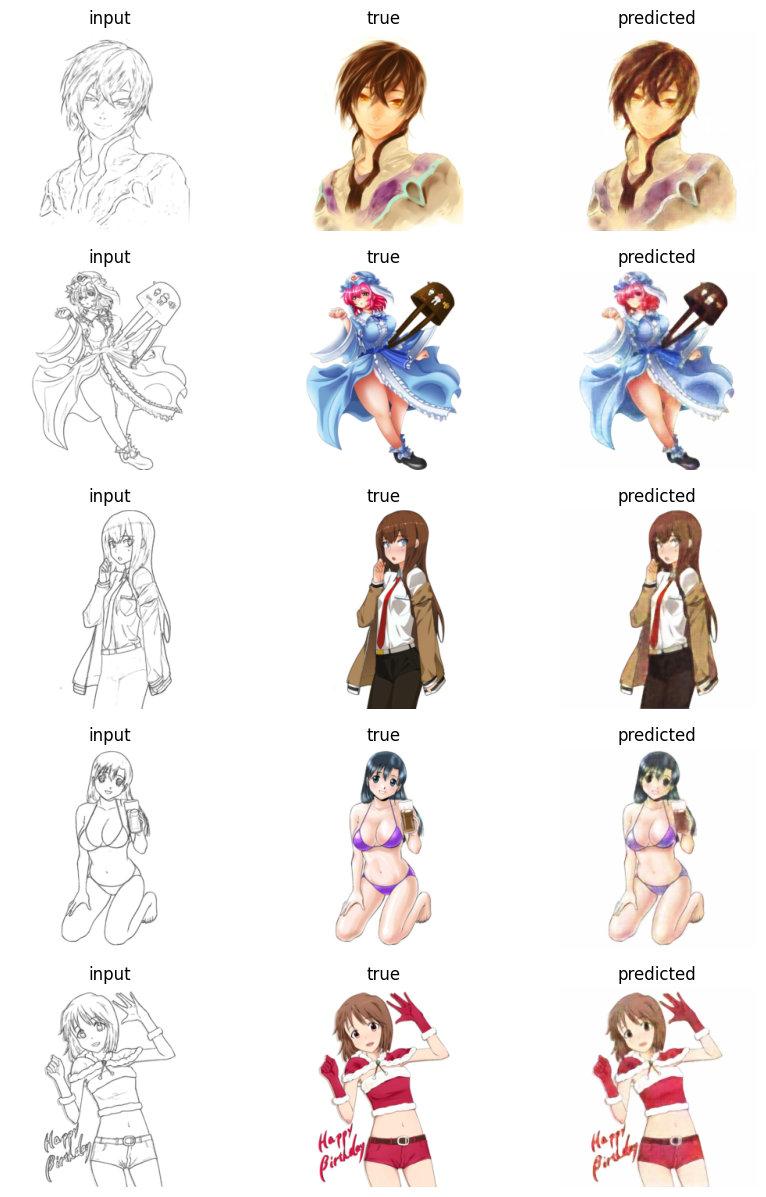

In [24]:
show_some_examples(cGAN, train_dataset)

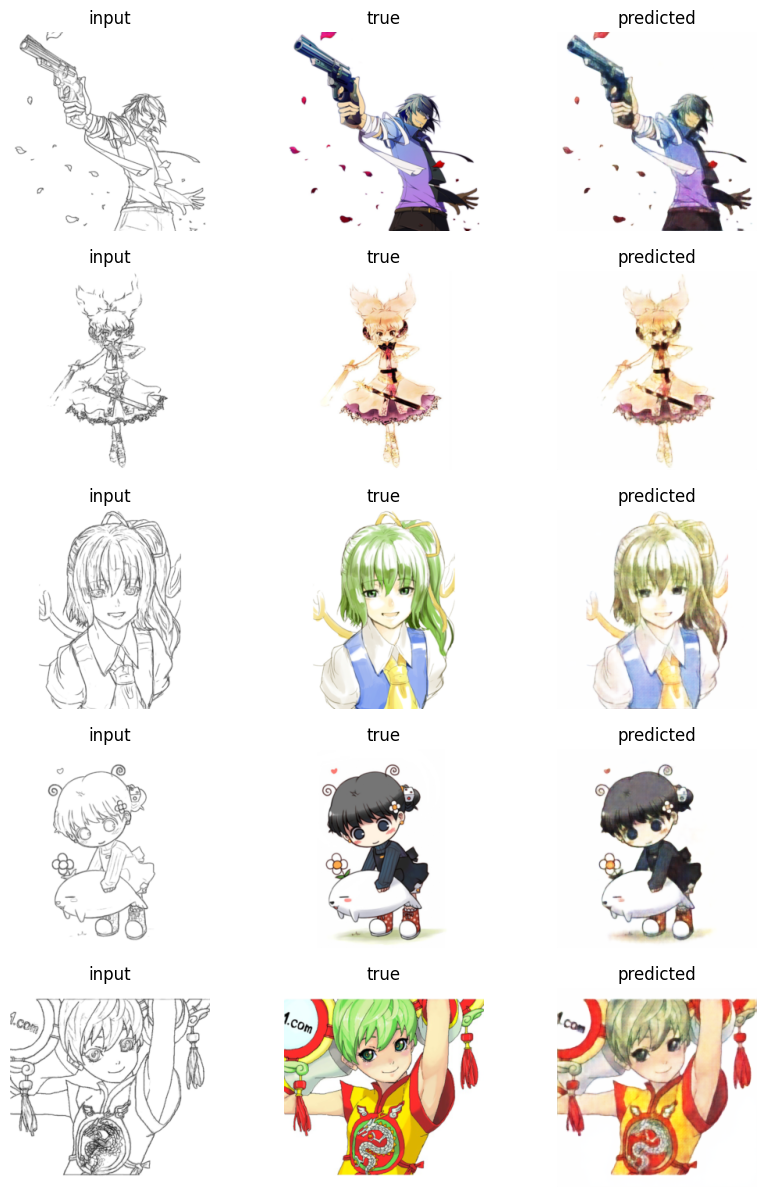

In [25]:
show_some_examples(cGAN, train_dataset)

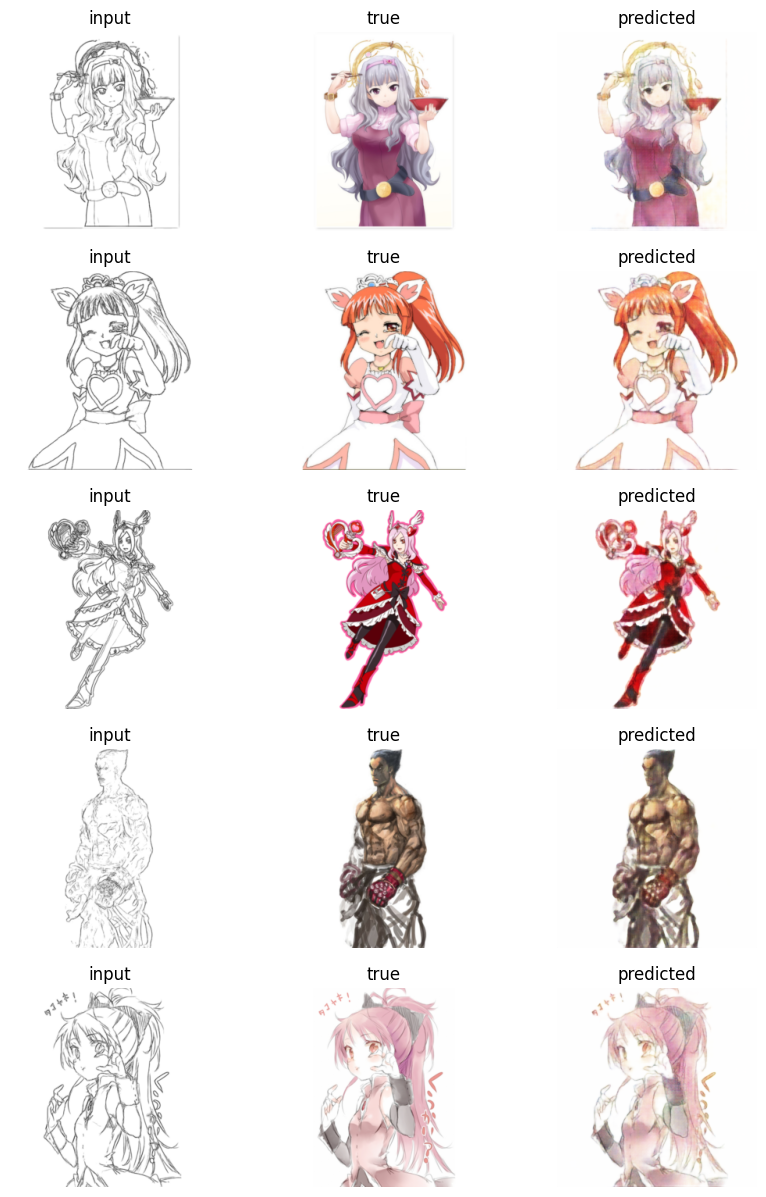

In [26]:
show_some_examples(cGAN, train_dataset)

# Overview

In this work, I trained a cGAN with BatchNorm2d, but there are some artifacts in the model's predictions. I plan to train a cGAN with InstanceNorm2d to see if this reduces the artifacts. Additionally, I plan to research how the l1_lambda parameter relates to the qualitative performance of colorization.